In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

suppressMessages(library(openair))
suppressMessages(library(BBmisc))
suppressMessages(library(caret))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=20,
        repr.plot.height=20,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Load Data

In [40]:
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
        filter(site == "es0118a") %>%
        timeAverage(avg.time = "day", type="variable")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es0118a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)

## Model Train and Prediction

In [56]:
main <- function(pll, df) {
    
    df <- df %>%
            filter(variable == pll)
    
    
    
    train <- which(df$date < ymd("2020-01-01"))
    test <- which(df$date > ymd("2020-01-01"))
    
    data.df <- df %>%
                select(-date, -variable) %>%
                normalize(method = "range", 
                          range = c(0, 1), margin = 1)
    
    # Set up the resampling, here repeated CV
    #tr <- trainControl(method = "repeatedcv",
    #                   number = 10, repeats = 5)
    
    model <- knnreg(formula = value ~., data = data.df[train,], 
                    k = 3, allowParallel=T)
    #model <- train(value ~., data=data.df, subset=train,
    #               na.action=na.omit,
    #               method="knn", 
    #               trControl = tr,
    #               tuneGrid=data.frame(k=3),
    #               allowParallel = TRUE)
    
    pred <- predict(model, newdata=data.df[test, -1], 
                    interval="confidence", level = 0.95)
    
    data.frame(variable = rep(pll, nrow(df[test,])),
               time = df[test, "date"],
               pred = pred,
               obs = data.df[test,]$value
              )    
}

In [57]:
model.df <-do.call(rbind, 
                   lapply(levels(as.factor(df$variable)), 
                          main, df))

In [58]:
head(model.df)

,variable,time,pred,obs
,<chr>,<date>,<dbl>,<dbl>
1,no,2020-01-02,0.6206711,0.25033993
2,no,2020-01-03,0.2384725,0.43858589
3,no,2020-01-04,0.1783250,0.03026859
4,no,2020-01-05,0.2902251,0.09125246
5,no,2020-01-06,0.3585134,0.14866294
6,no,2020-01-07,0.3277718,0.35376420


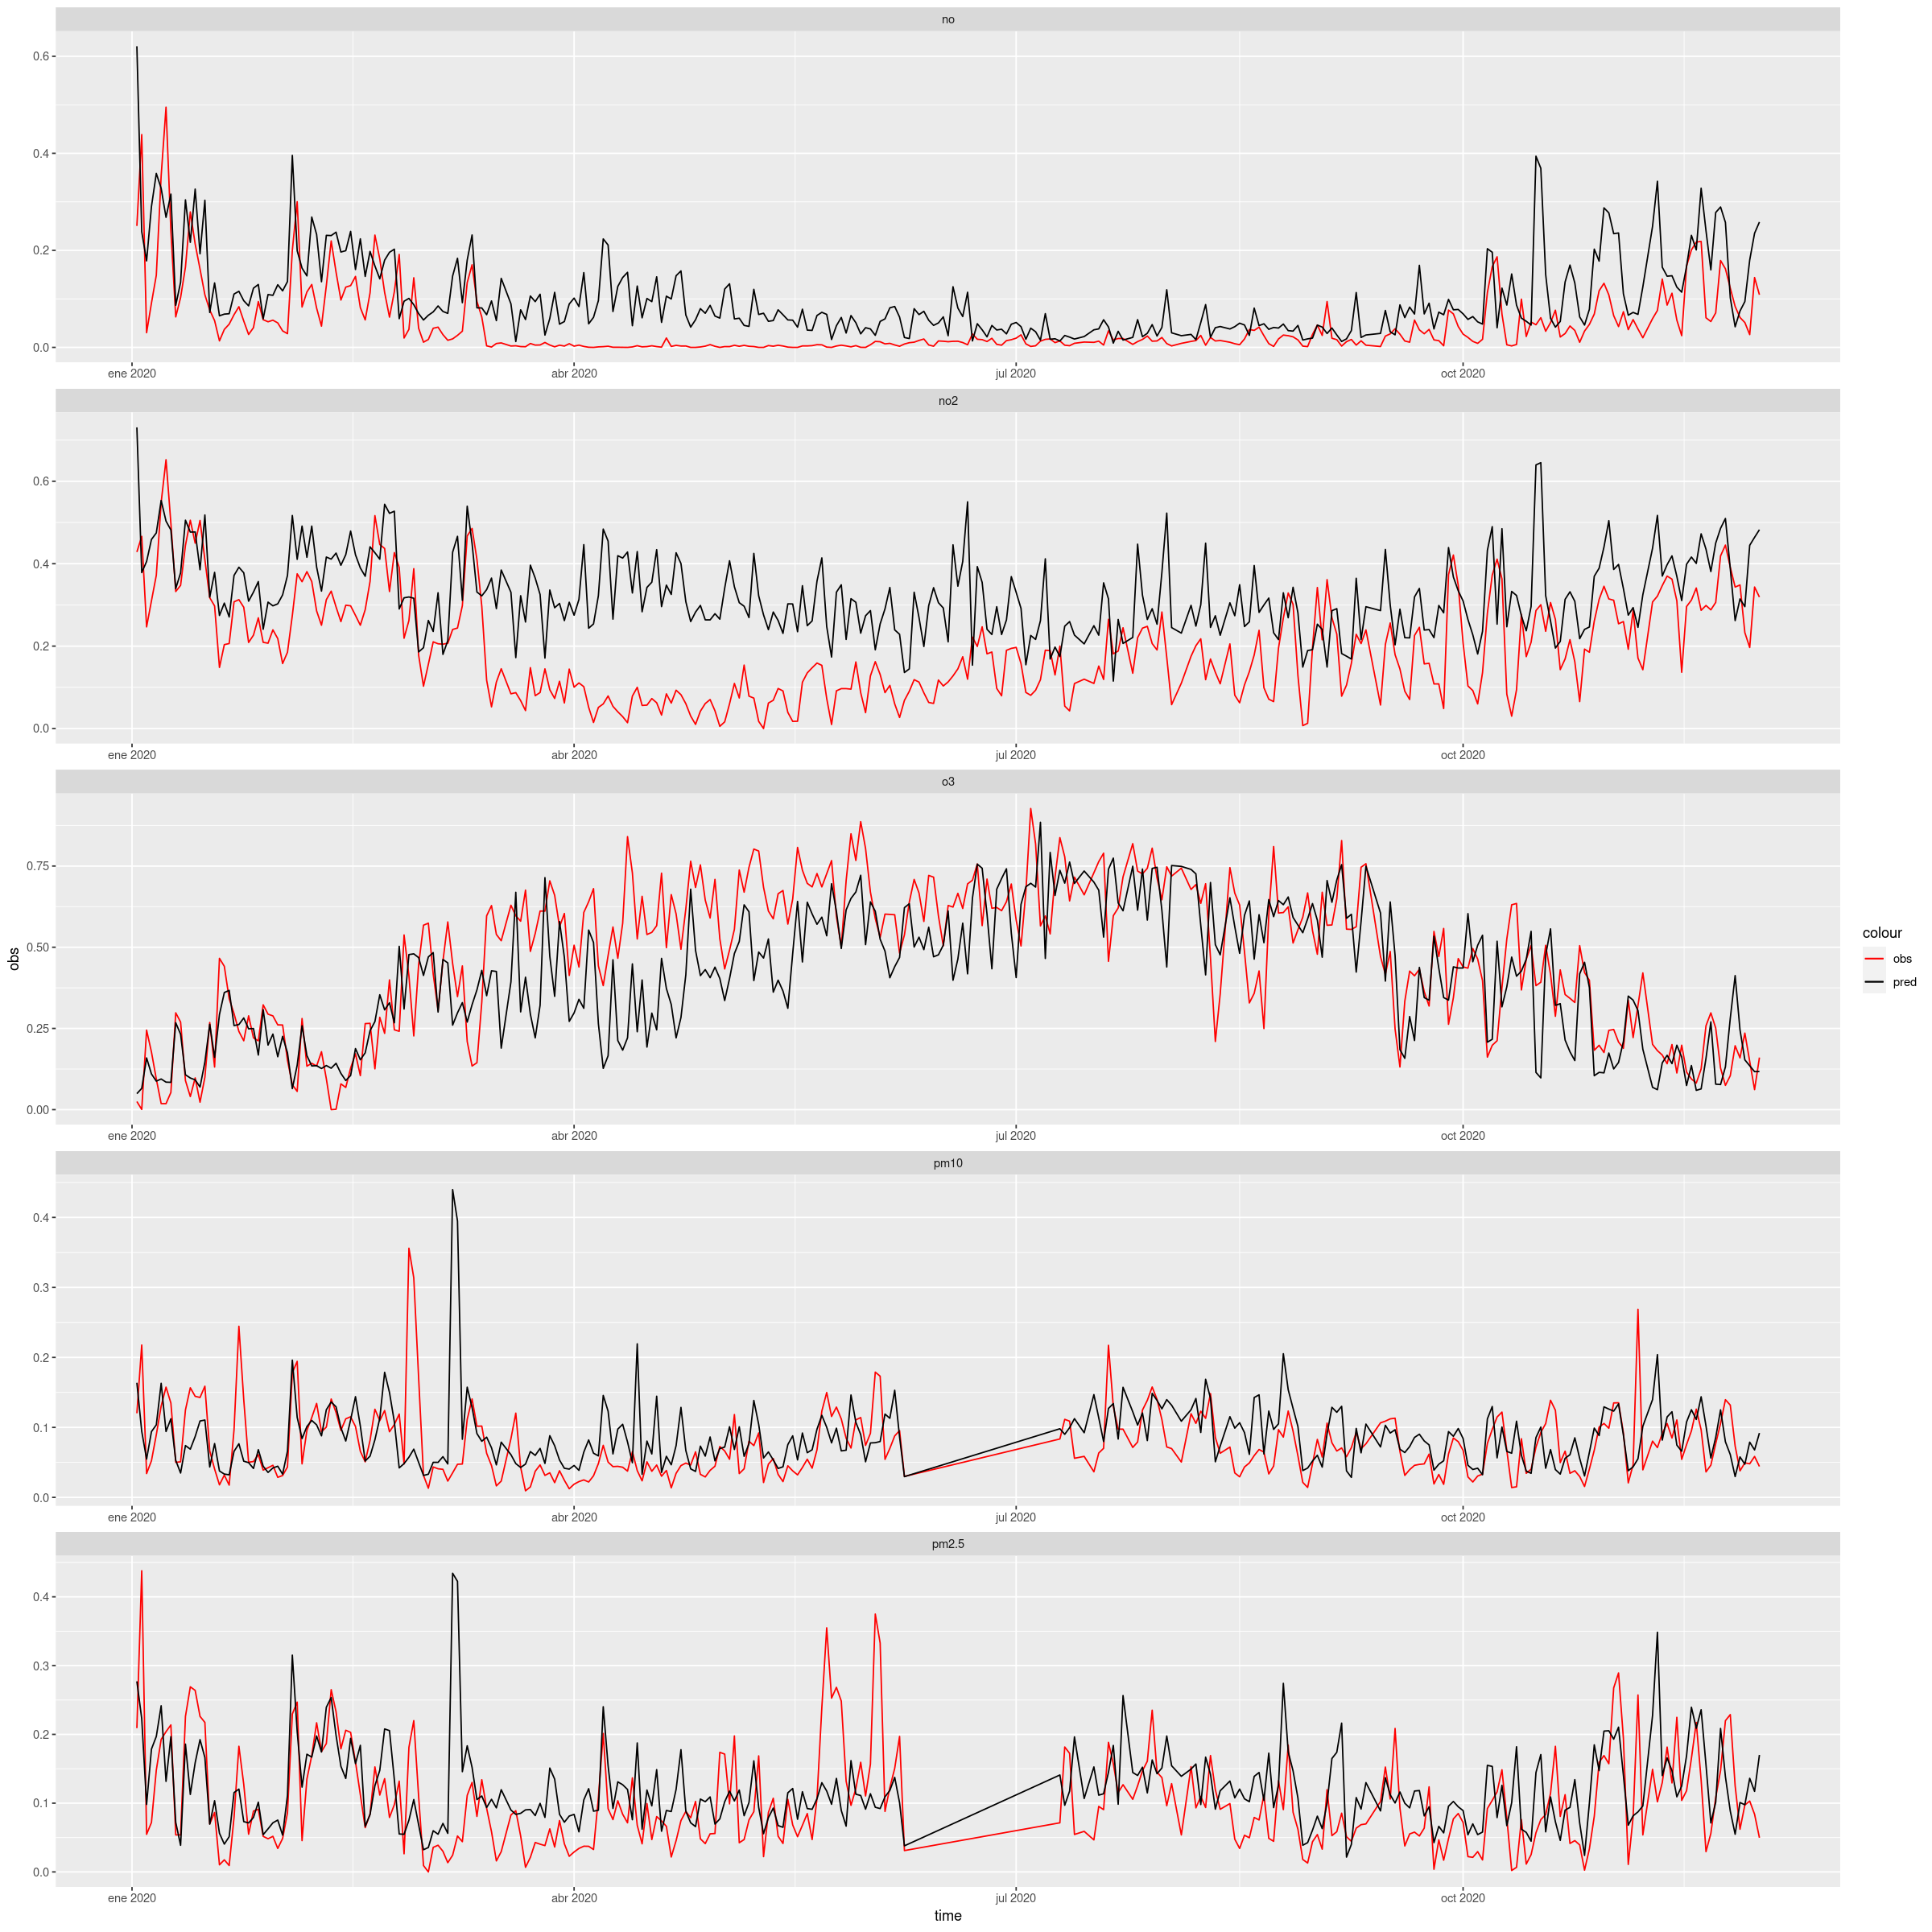

In [59]:
ggplot(data=model.df) +
    scale_color_manual(values=c("obs" = "red",
                         "pred" = "black")) +
    geom_line(aes(x=time, y=obs, color = "obs")) +
    geom_line(aes(x=time, y=pred, color = "pred")) +
    facet_wrap(~variable, scale="free", ncol=1)

In [60]:
model.df$diff <- model.df$obs - model.df$pred

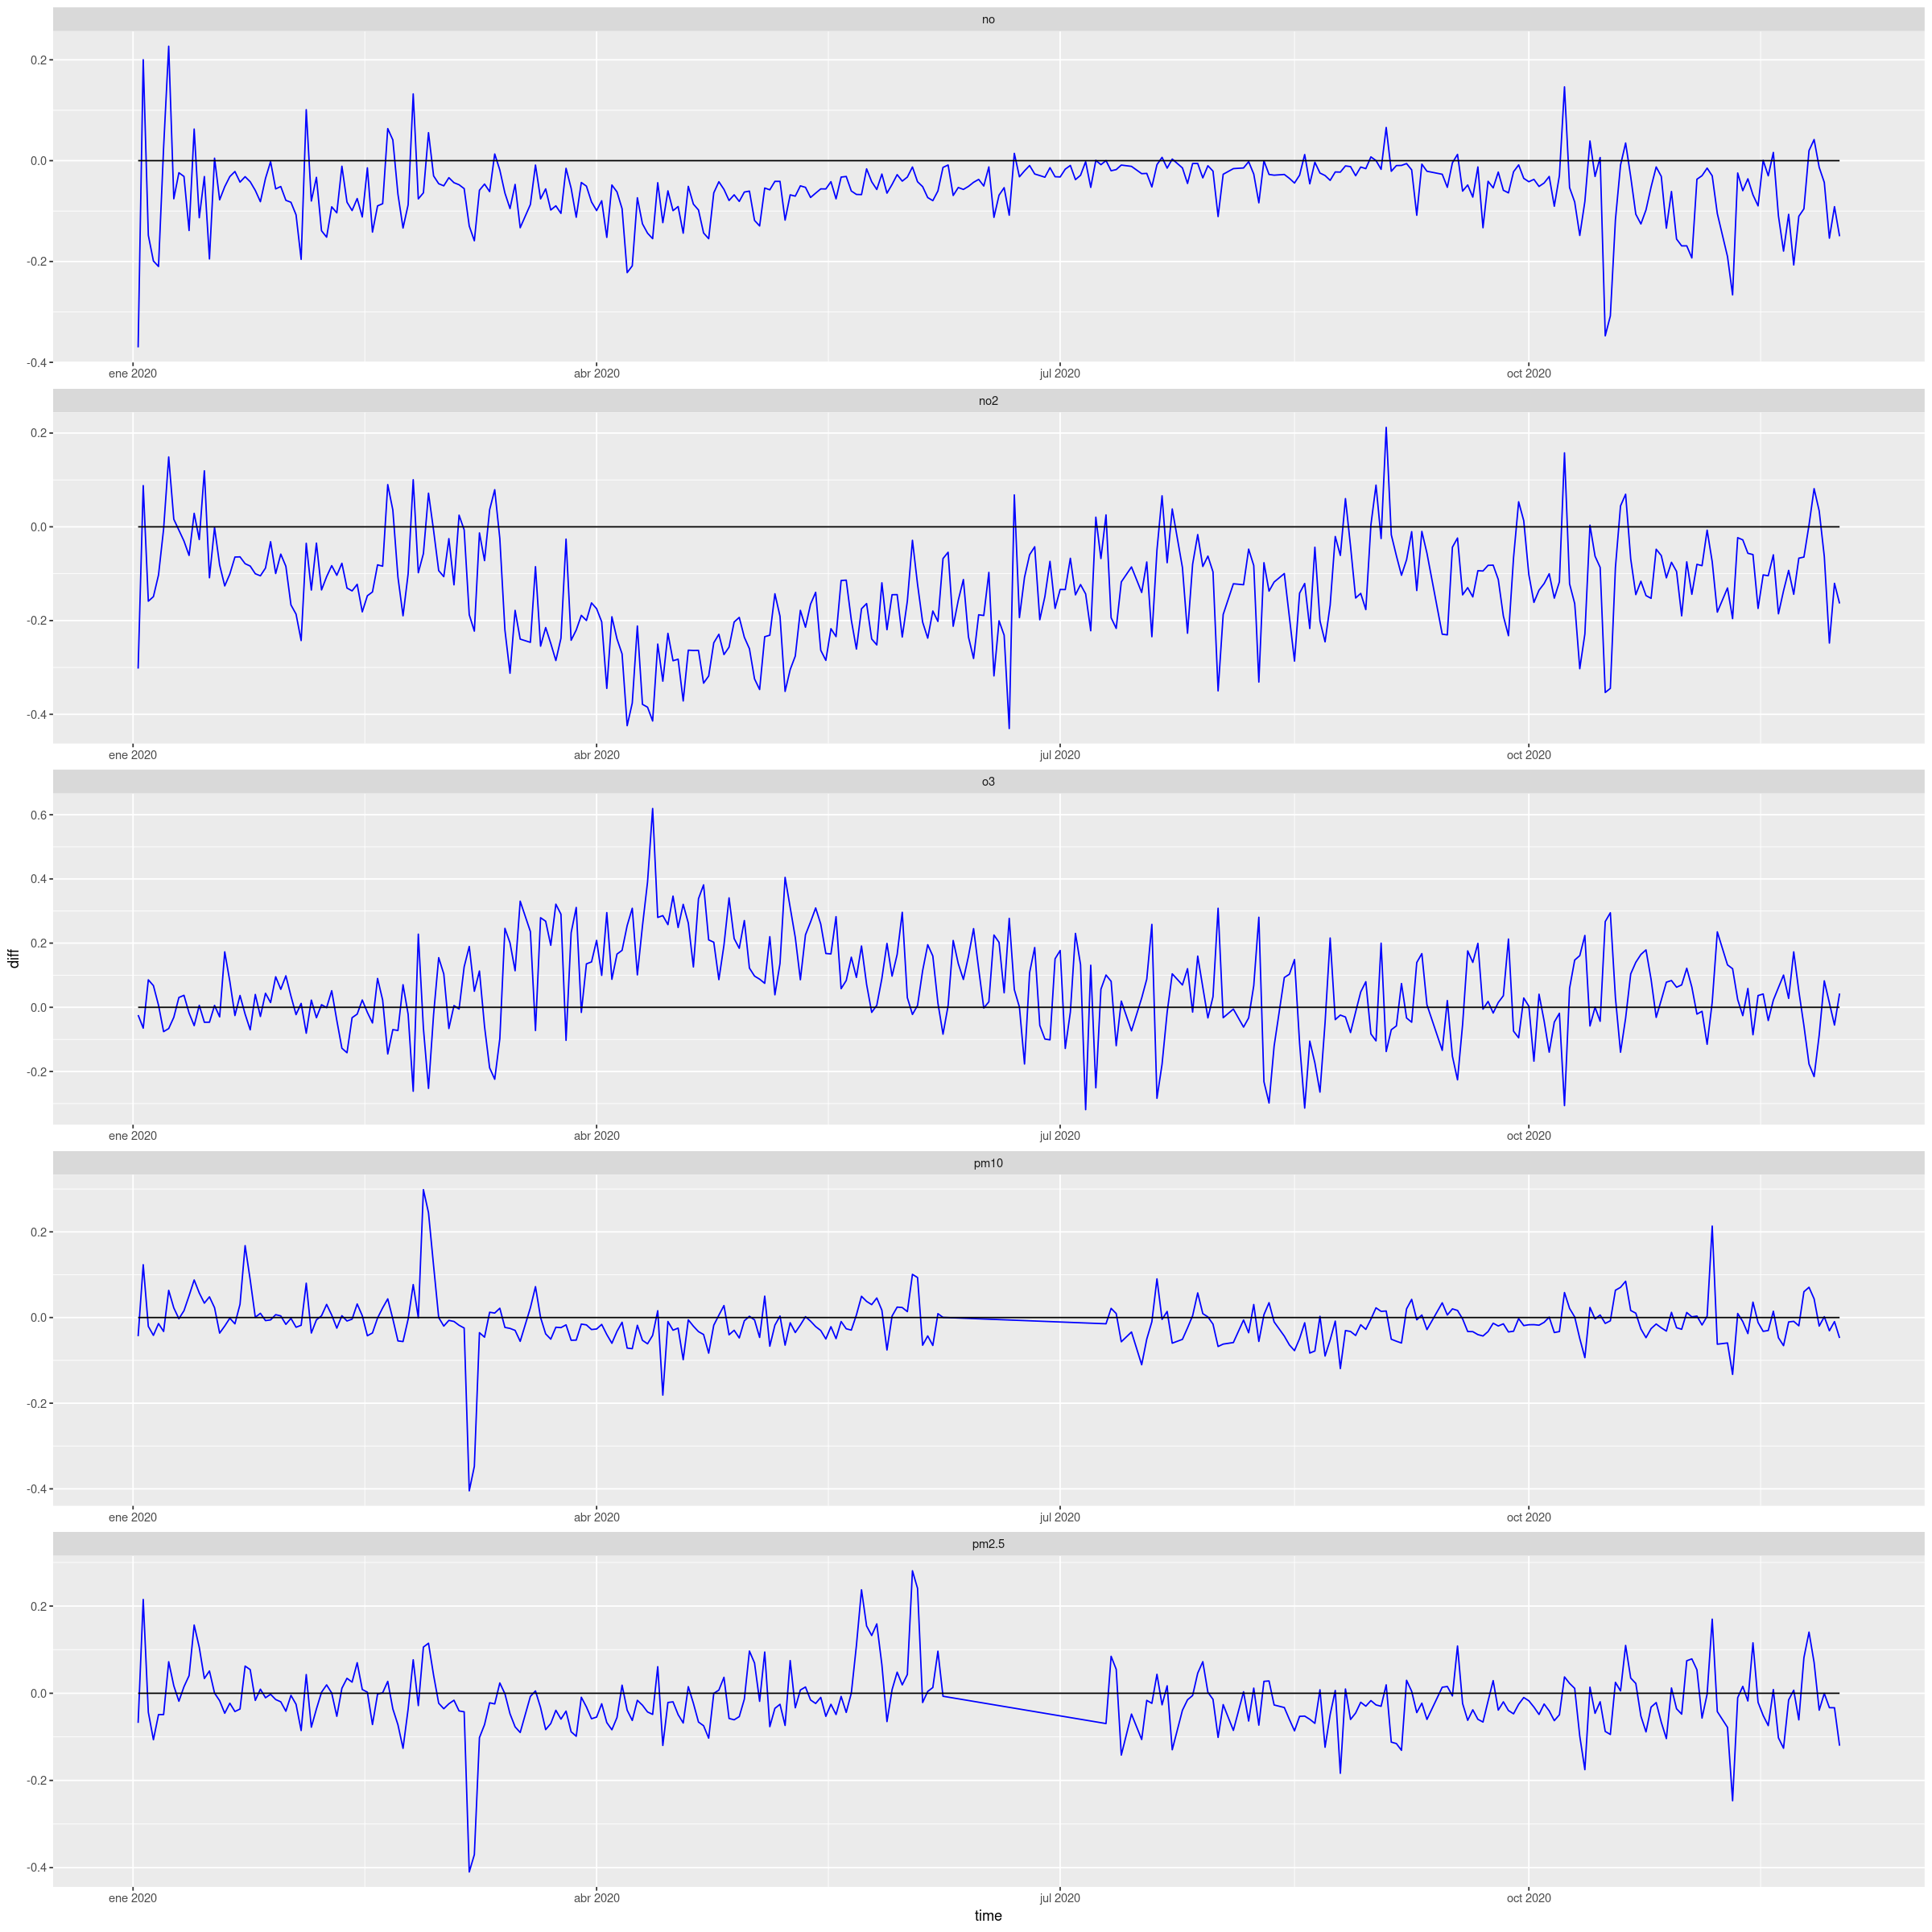

In [61]:
ggplot(model.df) +
    geom_line(aes(x=time, y=diff), color="blue") +
    geom_line(aes(x=time, y=0), color="black") +
    facet_wrap(~variable, scale="free", ncol=1)